In [597]:
import numpy as np

N, D = 7521, 1024   # ← whatever your total count and embedding dim are
doc_embeddings = np.memmap(
    "musique/musique_paragraphs_center_0.6B_embedding_0.npy",
    dtype="float32",
    mode="r",
    shape=(N, D)
)
doc_embeddings = np.array(doc_embeddings)
doc_embeddings[-1]

array([-0.06768497,  0.01194385, -0.01169097, ...,  0.04006547,
        0.03510926, -0.02700059], dtype=float32)

In [598]:
import numpy as np

N, D = 7521, 1024   # ← whatever your total count and embedding dim are
doc_embeddings_mp = np.memmap(
    "musique/musique_paragraphs_mp_0.6B_embedding_0.npy",
    dtype="float32",
    mode="r",
    shape=(N, D)
)
doc_embeddings_mp = np.array(doc_embeddings_mp)
doc_embeddings_mp[-1]

array([-0.06134128,  0.03226939, -0.01036966, ..., -0.00177213,
        0.01734047, -0.01817626], dtype=float32)

In [599]:
import numpy as np

N, D = 7521, 1024   # ← whatever your total count and embedding dim are
doc_embeddings_mp_context = np.memmap(
    "musique/musique_paragraphs_instruct_mp_context_0.6B_embedding_0.npy",
    dtype="float32",
    mode="r",
    shape=(N, D)
)
doc_embeddings_mp_context = np.array(doc_embeddings_mp_context)
doc_embeddings_mp_context[-1]

array([-0.05787248,  0.03407563, -0.00965403, ..., -0.00806922,
        0.01724079, -0.01797681], dtype=float32)

In [600]:
import numpy as np

N, D = 7521, 1024   # ← whatever your total count and embedding dim are
doc_embeddings_concat = np.memmap(
    "musique/musique_paragraphs_concat_0.6B_embedding_0.npy",
    dtype="float32",
    mode="r",
    shape=(N, D)
)
doc_embeddings_concat = np.array(doc_embeddings_concat)
doc_embeddings_concat[-1]

array([-0.02672534, -0.0026168 , -0.01089036, ..., -0.01258878,
        0.02392712, -0.01055369], dtype=float32)

In [601]:
import pickle
with open("musique/musique_paragraphs_neighbor_texts.pkl", "rb") as f:
    neighbor_texts = pickle.load(f)
len(neighbor_texts)

37852

In [602]:
import numpy as np

N, D = len(neighbor_texts), 1024   # ← whatever your total count and embedding dim are
neighbor_embeddings = np.memmap(
    "musique/musique_paragraphs_neighbor_0.6B_embedding_0.npy",
    dtype="float32",
    mode="r",
    shape=(N, D)
)
neighbor_embeddings = np.array(neighbor_embeddings)
neighbor_embeddings[-1]

array([-0.07204255, -0.00829221, -0.00295186, ..., -0.0073727 ,
        0.01150028, -0.02650032], dtype=float32)

In [603]:
import pickle
with open("musique/musique_paragraphs_concat_dict.pkl", "rb") as f:
    sub_docs_concat_dict = pickle.load(f)

In [604]:
neighbor_embeddings_combine = np.zeros_like(doc_embeddings)
idx = 0
for doc_idx, doc in enumerate(sub_docs_concat_dict):
    len_neighbor = len(doc['1'])
    if len_neighbor > 0:
        neighbor_embeddings_combine[doc_idx] = np.mean(neighbor_embeddings[idx:idx+len_neighbor], 0)
    idx += len_neighbor

In [605]:
import numpy as np

def self_anchored_weighting(center: np.ndarray, neighbors: np.ndarray) -> np.ndarray:
    """
    Compute self-anchored weighted mean of a center embedding with its neighbors.

    Args:
        center: (D,) center embedding
        neighbors: (N, D) neighbor embeddings

    Returns:
        (D,) aggregated embedding
    """
    # Normalize for cosine similarity
    center_norm = center / np.linalg.norm(center)
    neighbors_norm = neighbors / np.linalg.norm(neighbors, axis=1, keepdims=True)

    # Cosine similarities between center and neighbors
    sims = neighbors_norm @ center_norm  # shape (N,)

    # Weighted neighbor sum
    weighted_neighbors = np.sum(sims[:, None] * neighbors, axis=0)

    # Numerator and denominator
    numerator = center + weighted_neighbors
    denominator = 1.0 + np.sum(sims)

    return numerator / denominator

In [606]:
import numpy as np

def weighted_neighbor_sum(center: np.ndarray, neighbors: np.ndarray, use_softmax: bool = True) -> np.ndarray:
    """
    Compute weighted sum of neighbor embeddings based on similarity to center embedding.

    Args:
        center: (D,) center embedding
        neighbors: (N, D) neighbor embeddings
        use_softmax: whether to normalize weights with softmax (default True)

    Returns:
        (D,) weighted sum vector
    """
    # Normalize embeddings for cosine similarity
    center_norm = center / np.linalg.norm(center)
    neighbors_norm = neighbors / np.linalg.norm(neighbors, axis=1, keepdims=True)

    # Similarity scores (cosine)
    sims = neighbors_norm @ center_norm  # shape (N,)

    # Turn similarities into weights
    if use_softmax:
        exp_sims = np.exp(sims)
        weights = exp_sims / np.sum(exp_sims)
    else:
        weights = sims / np.sum(sims)

    # Weighted sum
    weighted_sum = weights @ neighbors  # shape (D,)
    return weighted_sum

In [607]:
neighbor_embeddings_combine_weighted = np.zeros_like(doc_embeddings)
idx = 0
for doc_idx, doc in enumerate(sub_docs_concat_dict):
    len_neighbor = len(doc['1'])
    if len_neighbor > 0:
        neighbor_embeddings_combine_weighted[doc_idx] = weighted_neighbor_sum(doc_embeddings[doc_idx], neighbor_embeddings[idx:idx+len_neighbor])
        # neighbor_embeddings_combine[doc_idx] = np.mean(neighbor_embeddings[idx:idx+len_neighbor], 0)
    idx += len_neighbor

In [608]:
weighted_neighbor_center = np.zeros_like(doc_embeddings)
idx = 0
for doc_idx, doc in enumerate(sub_docs_concat_dict):
    len_neighbor = len(doc['1'])
    if len_neighbor > 0:
        weighted_neighbor_center[doc_idx] = self_anchored_weighting(doc_embeddings[doc_idx], neighbor_embeddings[idx:idx+len_neighbor])
        # neighbor_embeddings_combine[doc_idx] = np.mean(neighbor_embeddings[idx:idx+len_neighbor], 0)
    idx += len_neighbor

In [609]:
mean_neighbor_center = 0.5 * doc_embeddings + 0.5 * neighbor_embeddings_combine

In [610]:
neighbor_embeddings_combine[0]

array([0.00053606, 0.00113894, 0.00087696, ..., 0.00928416, 0.0108516 ,
       0.01223676], dtype=float32)

In [611]:
import pickle
with open("musique/musique_paragraphs_concat_idx.pkl", "rb") as f:
    sub_paragraph_concat_idx = pickle.load(f)

In [612]:
import numpy as np

N, D = 400, 1024   # ← whatever your total count and embedding dim are
query_embeddings = np.memmap(
    "musique/query_task_instruct_0.6B_embedding_0.npy",
    dtype="float32",
    mode="r",
    shape=(N, D)
)
query_embeddings = np.array(query_embeddings)
query_embeddings[-1]

array([-0.01260294, -0.02232859, -0.00876494, ...,  0.00660737,
       -0.0251906 , -0.02212952], dtype=float32)

In [613]:
from multihop_data import load_adj, load_data_samples, load_docs
import csv
import json
import os

from collections import defaultdict
from huggingface_hub import hf_hub_download
from tqdm import tqdm

root_dir = "wiki_net"
os.makedirs(root_dir, exist_ok=True)

# nq_samples = load_data_samples("nq_filtered.jsonl")
musique_samples = load_data_samples("musique_400_250616.jsonl")
# docs = load_docs()
# adj = load_adj()

Found wiki_net/musique_400_250616.jsonl locally.


Loading samples: 400it [00:00, 11345.54it/s]


In [614]:
# rel_docs = []
# for sample in musique_samples:
#     rel_docs_cur = list(sample['p2d_id'].values())
#     rel_docs.append(rel_docs_cur)

In [615]:
import pickle
with open("musique/rel_paragraphs.pkl", "rb") as f:
    rel_docs = pickle.load(f)

In [616]:
num_answers = [len(i) for i in rel_docs]
np.mean(num_answers)

2.37

In [617]:
musique_samples[0]['p2d_id'], musique_samples[0]['question_decomposition'], musique_samples[0]['answer']

({'1': '50585', '3': '1946572', '16': '570934'},
 [{'id': 30654,
   'question': 'What religion did the black community found?',
   'answer': 'African Methodist Episcopal Church',
   'paragraph_support_idx': 1,
   'support_sentence': ["The state capital was moved from Philadelphia to Lancaster in 1799, then ultimately to Harrisburg in 1812. Philadelphia remained the nation's largest city until the late 18th century. It also was the nation's financial and cultural center until ultimately being eclipsed in total population by New York City in 1790. In 1816, the city's free Black community founded the African Methodist Episcopal Church, the first independent Black denomination in the country, and the first Black Episcopal Church. The free Black community also established many schools for its children with the help of Quakers. Large-scale construction projects for new roads, canals, and railroads made Philadelphia the first major industrial city in the United States."]},
  {'id': 128704,
  

In [618]:
key_doc_list = []
for sample in musique_samples:
    for question in sample['question_decomposition']:
        if question['answer'] == sample['answer']:
            support_idx = question['paragraph_support_idx']
    key_doc = sample['p2d_id'][str(support_idx)]
    key_doc_list.append([key_doc])

In [619]:
ground_truth_docnum = [sample['#_support_docs'] for sample in musique_samples]

In [620]:
import numpy as np
idx_1d = (np.array(ground_truth_docnum) == 4).nonzero()[0]
idx_1d

array([368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380,
       381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
       394, 395, 396, 397, 398, 399])

In [621]:
import numpy as np
from typing import List, Tuple

def ndcg_at_k_multi(query_embs: np.ndarray,
                    doc_embs:   np.ndarray,
                    relevant_doc_indices_list: List[List[int]],
                    idx_map: List,
                    k:          int = 10,
                   ) -> Tuple[np.ndarray, List[List[int]]]:
    """
    Compute nDCG@k for a batch of queries.

    Args:
        query_embs (np.ndarray): shape (Q, d). Each row is one query embedding.
        doc_embs   (np.ndarray): shape (N, d). Each row is one document embedding.
        relevant_doc_indices_list (List[List[int]]):
            A list of length Q.  Each element is a list of integer indices (0 <= idx < N)
            indicating which documents are relevant for that query.
        k (int): Rank cutoff (default 10).

    Returns:
        np.ndarray: shape (Q,), where element i is nDCG@k for query i.
                    If a query has no relevant docs (or IDCG=0), its score is defined to be 0.
    """
    # Basic sanity checks
    Q, d_q = query_embs.shape
    N, d_d = doc_embs.shape
    assert d_q == d_d, f"Embedding-dim mismatch: queries have dim {d_q}, docs have dim {d_d}"
    assert len(relevant_doc_indices_list) == Q, "You must supply exactly Q lists of relevant indices."

    # 1) Pre-normalize document embeddings (so we only do it once)
    doc_norms = np.linalg.norm(doc_embs, axis=1)
    zero_mask = (doc_norms == 0)
    # Avoid division by zero: for any zero-norm doc, set its unit vector to all zeros
    doc_norms[zero_mask] = 1.0
    doc_unit = doc_embs / doc_norms[:, np.newaxis]
    doc_unit[zero_mask] = 0.0  # explicitly zero out any row that was zero-norm

    # Prepare an array to hold all Q scores
    ndcg_scores = np.zeros(Q, dtype=float)

    # Precompute discount factors for positions 1..k (shared across all queries)
    positions = np.arange(1, k + 1)
    discount = 1.0 / np.log2(positions + 1)   # discount[j] = 1 / log2((j+1)+1) for j=0..k-1

    # 2) Loop over each query
    top_k_list = []
    for i in range(Q):
        q_emb = query_embs[i]
        rel_indices = relevant_doc_indices_list[i]  # list of ints in [0..N-1]

        # 2a) Normalize this query
        q_norm = np.linalg.norm(q_emb)
        if q_norm == 0:
            # If query is zero vector, we arbitrarily define its nDCG=0
            ndcg_scores[i] = 0.0
            continue
        q_unit = q_emb / q_norm

        # 2b) Compute cosine similarities: shape (N,)
        sims = doc_unit @ q_unit

        # 2c) Get top-k document indices (highest sims first)
        ranked = np.argsort(-sims)[:k]   # an array of length k
        ranked = [idx_map[i] for i in ranked]
        top_k_list.append(ranked)
        
        # 2d) Build a binary relevance vector `rels_topk` of length k
        #     rels_topk[j] = 1 if ranked[j] is in rel_indices, else 0
        rels_topk = np.zeros(k, dtype=float)
        if len(rel_indices) > 0:
            # We can speed up membership test by turning rel_indices into a set
            rel_set = set(rel_indices)
            for pos, doc_idx in enumerate(ranked):
                if doc_idx in rel_set:
                    rels_topk[pos] = 1.0

        # 2e) Compute DCG@k = sum_{j=1..k} (2^rel_j - 1) / log2(j+1)
        #     Since rel_j is either 0 or 1, (2^rel_j - 1) is just rel_j.
        gains = rels_topk   # (2^1 - 1) = 1, (2^0 - 1) = 0
        dcg  = np.sum(gains * discount)

        # 2f) Compute IDCG@k: when all relevant docs are packed at the top.
        #     If there are R = len(rel_indices) relevant docs, then ideal_rels = [1,1,1,...  R times ... , 0,0,...] truncated/padded to length k.
        R = min(len(rel_indices), k)
        if R == 0:
            # No relevant documents for this query → define nDCG=0
            ndcg_scores[i] = 0.0
            continue

        # top R positions each have relevance=1, so
        # IDCG = sum_{j=1..R} 1 / log2(j+1)
        ideal_dcg = np.sum(discount[:R])

        # 2g) nDCG = DCG / IDCG
        ndcg_scores[i] = (dcg / ideal_dcg) if (ideal_dcg > 0) else 0.0

    return ndcg_scores, top_k_list

In [622]:
from typing import List

def hit_ratio_at_k(
    topk_list: List[List[int]],
    relevant_list: List[List[int]],
    k: int = 10
) -> List[float]:
    """
    Compute the Hit-Ratio@k for each query.

    Args:
      topk_list:     List of length Q, each a list of the top-k retrieved doc IDs.
      relevant_list: List of length Q, each a list (or set) of true relevant doc IDs.
      k:             Cutoff (defaults to 10).

    Returns:
      List of length Q where each element is:
        len(relevant ∩ topk[:k]) / len(relevant)
      (0.0 if there are no relevant docs).
    """
    ratios = []
    for topk, rel in zip(topk_list, relevant_list):
        rel_set = set(rel)
        if not rel_set:
            # define hit-ratio as 0 when no ground-truth
            ratios.append(0.0)
        else:
            retrieved = set(topk[:k])
            ratios.append(len(rel_set & retrieved) / len(rel_set))
    return ratios

In [623]:
start_idx = 0
end_idx = 400

In [624]:
score, rank = ndcg_at_k_multi(query_embeddings[start_idx:end_idx],doc_embeddings,rel_docs[start_idx:end_idx],sub_paragraph_concat_idx, 10)
hit = hit_ratio_at_k(rank, rel_docs[start_idx:end_idx])
score, np.mean(score), np.mean(hit)

(array([0.14804096, 0.13565197, 0.46927873, 0.67138607, 0.23463936,
        0.46927873, 0.46927873, 0.46927873, 0.46927873, 0.        ,
        0.13565197, 0.46927873, 0.63643918, 0.14126697, 0.16716045,
        0.46927873, 0.3044672 , 0.38364914, 0.        , 0.90602544,
        0.23463936, 0.46927873, 0.46927873, 0.15642624, 0.        ,
        0.6049307 , 0.14804096, 0.        , 0.23463936, 0.        ,
        0.14126697, 0.46927873, 0.20210735, 0.18154179, 0.14126697,
        0.6049307 , 0.        , 0.        , 0.45250815, 0.        ,
        0.        , 0.23463936, 0.46927873, 0.29608191, 0.3692678 ,
        0.        , 0.23463936, 0.46927873, 0.        , 0.46927873,
        0.46927873, 0.14126697, 0.62570497, 0.40179982, 0.46927873,
        0.15642624, 0.14126697, 0.46927873, 0.        , 0.35853359,
        0.46927873, 0.        , 0.76536064, 0.        , 0.31520141,
        0.14126697, 0.33796803, 0.29608191, 0.        , 0.46927873,
        0.23463936, 0.46927873, 0.6049307 , 0.15

In [625]:
score_concat, rank_concat = ndcg_at_k_multi(query_embeddings[start_idx:end_idx],doc_embeddings_concat,rel_docs[start_idx:end_idx], sub_paragraph_concat_idx, 10)
hit_concat = hit_ratio_at_k(rank_concat, rel_docs[start_idx:end_idx])
score_concat, np.mean(score_concat), np.mean(hit_concat)

(array([0.76536064, 0.18154179, 0.49818926, 0.71226307, 0.6105457 ,
        0.15642624, 0.18154179, 0.76536064, 0.61731968, 0.28930793,
        0.34870225, 0.93252109, 0.62570497, 0.81798097, 0.57239868,
        0.88545988, 0.40179982, 0.4776237 , 0.62570497, 0.46927873,
        0.40179982, 0.40179982, 0.        , 0.46927873, 0.29608191,
        0.63643918, 0.63643918, 0.3692678 , 0.82781231, 0.14804096,
        0.29608191, 0.29608191, 0.33796803, 0.46927873, 0.        ,
        0.76536064, 0.29608191, 0.43674671, 0.62570497, 0.14126697,
        0.65082052, 0.38268032, 0.46927873, 0.6049307 , 0.6049307 ,
        0.67138607, 0.29769321, 0.80724676, 0.63643918, 0.46927873,
        0.91340159, 0.46927873, 0.88545988, 0.70391809, 0.46927873,
        0.29608191, 0.46927873, 0.62570497, 0.        , 0.6049307 ,
        0.76536064, 0.18154179, 0.84518506, 0.76536064, 0.23463936,
        0.46927873, 0.85292787, 0.        , 0.        , 0.43734888,
        0.46927873, 0.76536064, 0.49818926, 0.18

In [626]:
# hit_key = hit_ratio_at_k(rank, key_doc_list[start_idx:end_idx])
# np.mean(hit_key)

In [627]:
score_mp, rank_mp = ndcg_at_k_multi(query_embeddings[start_idx:end_idx],doc_embeddings_mp,rel_docs[start_idx:end_idx], sub_paragraph_concat_idx, 10)
hit_mp = hit_ratio_at_k(rank_mp, rel_docs[start_idx:end_idx])
score_mp, np.mean(score_mp), np.mean(hit_mp)

(array([0.65082052, 0.18154179, 0.43674671, 0.68714752, 0.63643918,
        0.15642624, 0.65082052, 0.46927873, 0.39106561, 0.32958275,
        0.70391809, 0.76536064, 0.63643918, 0.91340159, 0.43674671,
        0.85195904, 0.61731968, 0.65082052, 0.46927873, 0.6049307 ,
        0.49818926, 0.43674671, 0.46927873, 0.63643918, 0.4776237 ,
        0.46927873, 0.76536064, 0.6105457 , 0.83854653, 0.23463936,
        0.        , 0.49818926, 0.46324237, 0.6049307 , 0.        ,
        0.96746798, 0.32958275, 0.44412287, 0.34337432, 0.29608191,
        0.62570497, 0.38364914, 0.61731968, 0.46927873, 0.62570497,
        0.33775932, 0.6105457 , 0.61731968, 0.29608191, 0.29608191,
        0.96746798, 0.46927873, 0.67138607, 0.79886147, 0.46927873,
        0.27691895, 0.        , 0.29769321, 0.        , 0.63643918,
        0.46927873, 0.29608191, 0.63643918, 0.49818926, 0.23463936,
        0.46927873, 0.85292787, 0.46927873, 0.29608191, 0.53072127,
        0.        , 0.76536064, 0.6546155 , 0.13

In [628]:
score_mp_context, rank_mp_context = ndcg_at_k_multi(query_embeddings[start_idx:end_idx],doc_embeddings_mp_context,rel_docs[start_idx:end_idx], sub_paragraph_concat_idx, 10)
hit_mp_context = hit_ratio_at_k(rank_mp_context, rel_docs[start_idx:end_idx])
score_mp_context, np.mean(score_mp_context), np.mean(hit_mp_context)

(array([0.61731968, 0.        , 0.43674671, 0.68714752, 0.67138607,
        0.20210735, 0.76536064, 0.76536064, 0.23463936, 0.28930793,
        0.67138607, 0.76536064, 0.80703805, 0.93252109, 0.40179982,
        0.66637325, 0.61731968, 0.63643918, 0.29608191, 0.76135694,
        0.65082052, 0.43674671, 0.62570497, 0.61731968, 0.65082052,
        0.61731968, 0.93252109, 0.62570497, 0.90662761, 0.46927873,
        0.46927873, 0.49818926, 0.77209115, 0.6049307 , 0.        ,
        1.        , 0.        , 0.44412287, 0.41618116, 0.29608191,
        0.70391809, 0.4776237 , 0.63643918, 0.43674671, 0.67138607,
        0.20210735, 0.67138607, 0.92178688, 0.46927873, 0.29608191,
        0.85195904, 0.90101261, 0.67138607, 0.86034433, 0.46927873,
        0.14804096, 0.29608191, 0.43734888, 0.        , 0.63643918,
        0.13565197, 0.29608191, 0.83957006, 0.70391809, 0.23463936,
        0.46927873, 0.6182885 , 0.46927873, 0.38364914, 0.70391809,
        0.34870225, 0.70391809, 0.81265305, 0.29

In [629]:
score_post_mean, rank_post_mean = ndcg_at_k_multi(query_embeddings[start_idx:end_idx],mean_neighbor_center,rel_docs[start_idx:end_idx],sub_paragraph_concat_idx, 10)
hit_post_mean = hit_ratio_at_k(rank_post_mean, rel_docs[start_idx:end_idx])
score_post_mean, np.mean(score_post_mean), np.mean(hit_post_mean)

(array([0.61731968, 0.15642624, 0.63643918, 0.76536064, 0.38364914,
        0.46927873, 0.76536064, 0.67138607, 0.46927873, 0.        ,
        0.37029134, 0.61731968, 0.79286542, 0.61731968, 0.43734888,
        0.70391809, 0.3501483 , 0.20210735, 0.46927873, 0.90602544,
        0.6049307 , 0.4776237 , 0.46927873, 0.18154179, 0.29608191,
        0.43734888, 0.39106561, 0.23463936, 0.81798097, 0.16716045,
        0.46927873, 0.63643918, 0.40179982, 0.18154179, 0.        ,
        0.67138607, 0.        , 0.16716045, 0.43674671, 0.29608191,
        0.46927873, 0.44412287, 0.46927873, 0.29608191, 0.4776237 ,
        0.18154179, 0.4776237 , 0.76536064, 0.        , 0.49818926,
        0.65082052, 0.14126697, 0.67138607, 0.54007538, 0.90101261,
        0.15642624, 0.29608191, 0.46927873, 0.        , 0.55183313,
        0.46927873, 0.        , 0.86034433, 0.40179982, 0.20210735,
        0.29608191, 0.6182885 , 0.13565197, 0.13565197, 0.70391809,
        0.16716045, 0.65082052, 0.46927873, 0.29

In [630]:
score_post_weighted, rank_post_weighted = ndcg_at_k_multi(query_embeddings[start_idx:end_idx],weighted_neighbor_center,rel_docs[start_idx:end_idx],sub_paragraph_concat_idx, 10)
hit_post_weighted = hit_ratio_at_k(rank_post_weighted, rel_docs[start_idx:end_idx])
score_post_weighted, np.mean(score_post_weighted), np.mean(hit_post_weighted)

(array([0.46927873, 0.16716045, 0.43674671, 0.76536064, 0.41618116,
        0.29608191, 0.76536064, 0.76536064, 0.76536064, 0.        ,
        0.35853359, 0.76536064, 0.90101261, 0.83854653, 0.41618116,
        0.53072127, 0.61731968, 0.37029134, 0.46927873, 0.90662761,
        0.63643918, 0.63643918, 0.46927873, 0.62570497, 0.46927873,
        0.29608191, 0.92178688, 0.46927873, 0.92178688, 0.20210735,
        0.29608191, 0.67138607, 0.6049307 , 0.33796803, 0.        ,
        0.93252109, 0.46927873, 0.29608191, 0.41618116, 0.29608191,
        0.46927873, 0.46324237, 0.46927873, 0.63643918, 0.65082052,
        0.20210735, 0.70391809, 0.87107854, 0.        , 0.49818926,
        0.85195904, 0.38364914, 0.76536064, 0.87107854, 0.46927873,
        0.        , 0.46927873, 0.6049307 , 0.        , 0.57239868,
        0.46927873, 0.23463936, 0.90602544, 0.49818926, 0.16716045,
        0.29608191, 0.67973105, 0.46927873, 0.4776237 , 0.76536064,
        0.16716045, 0.70391809, 0.78647249, 0.46

In [631]:
# hit_key_mp = hit_ratio_at_k(rank_mp, key_doc_list[start_idx:end_idx])
# np.mean(hit_key_mp)

In [632]:
alphas = np.arange(0, 1.02, 0.02)
score_combine_list = []
hit_combine_list = []
for alpha in alphas:
    print(alpha)
    doc_embeddings_combine = np.zeros_like(doc_embeddings)
    for i in range(7521):
        doc_embeddings_combine[i] = alpha * doc_embeddings[i] + (1-alpha) * doc_embeddings_mp_context[sub_paragraph_concat_idx.index(sub_paragraph_concat_idx[i])]
    score_combine, rank_combine = ndcg_at_k_multi(query_embeddings[start_idx:end_idx],doc_embeddings_combine,rel_docs[start_idx:end_idx], sub_paragraph_concat_idx, 10)
    hit_combine = hit_ratio_at_k(rank_combine, rel_docs[start_idx:end_idx])
    score_combine_list.append(np.mean(score_combine))
    hit_combine_list.append(np.mean(hit_combine))

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
1.0


In [633]:
np.max(score_combine_list), alphas[np.argmax(score_combine_list)], score_combine_list[0], score_combine_list[-1]

(0.6691033296184529, 0.34, 0.6184371694682962, 0.540983626246185)

In [634]:
np.max(hit_combine_list), alphas[np.argmax(hit_combine_list)]

(0.744375, 0.24)

In [635]:
alphas = np.arange(0, 1.02, 0.02)
score_combine_list_mean_neighbor = []
hit_combine_list_mean_neighbor = []
for alpha in alphas:
    print(alpha)
    doc_embeddings_combine = np.zeros_like(doc_embeddings)
    for i in range(7521):
        doc_embeddings_combine[i] = alpha * doc_embeddings[i] + (1-alpha) * neighbor_embeddings_combine[sub_paragraph_concat_idx.index(sub_paragraph_concat_idx[i])]
    score_combine, rank_combine = ndcg_at_k_multi(query_embeddings[start_idx:end_idx],doc_embeddings_combine,rel_docs[start_idx:end_idx], sub_paragraph_concat_idx, 10)
    hit_combine = hit_ratio_at_k(rank_combine, rel_docs[start_idx:end_idx])
    score_combine_list_mean_neighbor.append(np.mean(score_combine))
    hit_combine_list_mean_neighbor.append(np.mean(hit_combine))

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
1.0


In [636]:
alphas = np.arange(0, 1.02, 0.02)
score_combine_list_weight_neighbor = []
hit_combine_list_weight_neighbor = []
for alpha in alphas:
    print(alpha)
    doc_embeddings_combine = np.zeros_like(doc_embeddings)
    for i in range(7521):
        doc_embeddings_combine[i] = alpha * doc_embeddings[i] + (1-alpha) * neighbor_embeddings_combine_weighted[sub_paragraph_concat_idx.index(sub_paragraph_concat_idx[i])]
    score_combine, rank_combine = ndcg_at_k_multi(query_embeddings[start_idx:end_idx],doc_embeddings_combine,rel_docs[start_idx:end_idx], sub_paragraph_concat_idx, 10)
    hit_combine = hit_ratio_at_k(rank_combine, rel_docs[start_idx:end_idx])
    score_combine_list_weight_neighbor.append(np.mean(score_combine))
    hit_combine_list_weight_neighbor.append(np.mean(hit_combine))

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
1.0


In [637]:
alphas = np.arange(0, 1.02, 0.02)
score_combine_list_concat = []
hit_combine_list_concat = []
for alpha in alphas:
    print(alpha)
    doc_embeddings_combine = np.zeros_like(doc_embeddings)
    for i in range(7521):
        doc_embeddings_combine[i] = alpha * doc_embeddings[i] + (1-alpha) * doc_embeddings_concat[sub_paragraph_concat_idx.index(sub_paragraph_concat_idx[i])]
    score_combine, rank_combine = ndcg_at_k_multi(query_embeddings[start_idx:end_idx],doc_embeddings_combine,rel_docs[start_idx:end_idx], sub_paragraph_concat_idx, 10)
    hit_combine = hit_ratio_at_k(rank_combine, rel_docs[start_idx:end_idx])
    score_combine_list_concat.append(np.mean(score_combine))
    hit_combine_list_concat.append(np.mean(hit_combine))

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
1.0


In [638]:
alphas = np.arange(0, 1.02, 0.02)
score_combine_list_mp = []
hit_combine_list_mp = []
for alpha in alphas:
    print(alpha)
    doc_embeddings_combine = np.zeros_like(doc_embeddings)
    for i in range(7521):
        doc_embeddings_combine[i] = alpha * doc_embeddings[i] + (1-alpha) * doc_embeddings_mp[sub_paragraph_concat_idx.index(sub_paragraph_concat_idx[i])]
    score_combine, rank_combine = ndcg_at_k_multi(query_embeddings[start_idx:end_idx],doc_embeddings_combine,rel_docs[start_idx:end_idx], sub_paragraph_concat_idx, 10)
    hit_combine = hit_ratio_at_k(rank_combine, rel_docs[start_idx:end_idx])
    score_combine_list_mp.append(np.mean(score_combine))
    hit_combine_list_mp.append(np.mean(hit_combine))

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
1.0


In [639]:
alphas = np.arange(0, 1.02, 0.02)
score_combine_list_mp_context = []
hit_combine_list_mp_context = []
for alpha in alphas:
    print(alpha)
    doc_embeddings_combine = np.zeros_like(doc_embeddings)
    for i in range(7521):
        doc_embeddings_combine[i] = alpha * doc_embeddings[i] + (1-alpha) * doc_embeddings_mp_context[sub_paragraph_concat_idx.index(sub_paragraph_concat_idx[i])]
    score_combine, rank_combine = ndcg_at_k_multi(query_embeddings[start_idx:end_idx],doc_embeddings_combine,rel_docs[start_idx:end_idx], sub_paragraph_concat_idx, 10)
    hit_combine = hit_ratio_at_k(rank_combine, rel_docs[start_idx:end_idx])
    score_combine_list_mp_context.append(np.mean(score_combine))
    hit_combine_list_mp_context.append(np.mean(hit_combine))

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7000000000000001
0.72
0.74
0.76
0.78
0.8
0.8200000000000001
0.84
0.86
0.88
0.9
0.92
0.9400000000000001
0.96
0.98
1.0


In [640]:
import matplotlib.pyplot as plt
import numpy as np

def plot_alpha_variance(save_path="alpha_variance.pdf"):
    # X-axis: alpha values
    alphas = np.arange(0, 1.02, 0.02)

    # Create plot
    plt.figure(figsize=(8, 6))
    plt.plot(alphas, score_combine_list_mean_neighbor, marker="o", markersize=2, label="Mean Neighbor")
    plt.plot(alphas, score_combine_list_weight_neighbor, marker="o", markersize=2, label="Weighted Mean Neighbor")
    plt.plot(alphas, score_combine_list_concat, marker="o", markersize=2, label="Struc-Emb-Seq")
    plt.plot(alphas, score_combine_list_mp, marker="o", markersize=2, label="Struc-Emb-Par")
    plt.plot(alphas, score_combine_list_mp_context, marker="o", markersize=2, label="Struc-Emb-Par-Distill")
    # plt.figure(figsize=(8, 6))
    # plt.plot(alphas, score_combine_list_mean_neighbor, label="Mean Neighbor")
    # plt.plot(alphas, score_combine_list_weight_neighbor, label="Weighted Mean Neighbor")
    # plt.plot(alphas, score_combine_list_concat, label="Struc-Emb-Seq")
    # plt.plot(alphas, score_combine_list_mp, label="Struc-Emb-Par")
    # plt.plot(alphas, score_combine_list_mp_context, label="Struc-Emb-Par-Distill")

    # Labels, title, legend, and grid (larger fonts, consistent with your style)
    plt.xlabel(r"Interpolation Weight $\alpha$", fontsize=15)
    plt.ylabel("Retrieval performance (nDCG@10)", fontsize=15)
    plt.title("Performance Variation with Interpolation Weight", fontsize=16)
    plt.legend(fontsize=12, loc="best")
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Save and show
    plt.savefig(save_path, format="pdf")
    plt.show()
    plt.close()


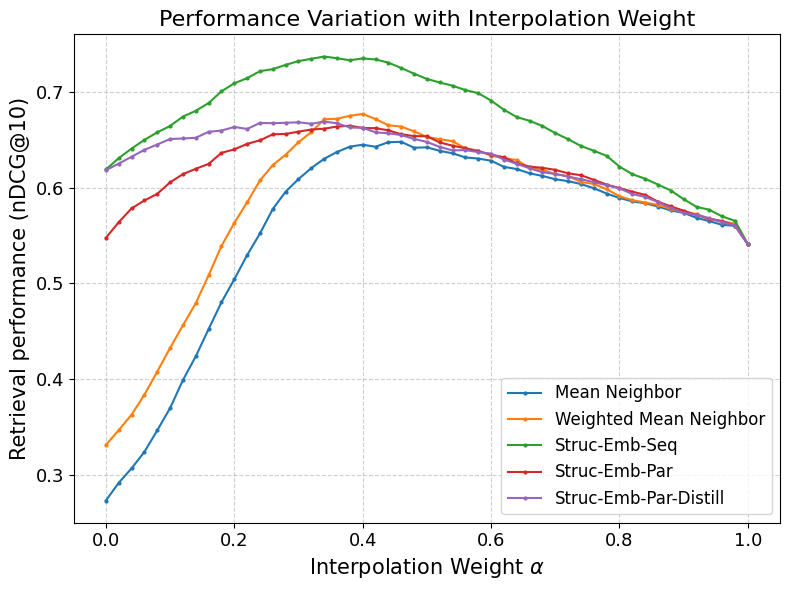

In [641]:
plot_alpha_variance(save_path="alpha_variance_0.6B_top5_degree.pdf")